### Ben Christensen
### Homework 4
### Predicting Titanic Survivors
### March 8, 2018

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB
from collections import Counter
import math
%matplotlib inline

### Describing Data

In [2]:
X = pd.read_csv("train_titanic.csv")
X.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
X.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age has a significant amount of missing observations (20%) and Cabin is missing most of its observations (77%). I will need to address this.

From my training set I drop the variables:
* Passenger ID
* Cabin

Passenger ID was created by Kaggle so it shouldn't be useful here. For the variable "name", I considered checking for each individual, how many other people aboard the Titanic have the same last name, but that would mostly be a proxy for how many relatives are aboard. We already have two variables that measure that: sbisp and parch. Instead, perhaps the alphabetical order of the last name may have been used in deciding where to house passengers. So I create a variable for the first letter of the last name. Also, before dropping the "Cabin" variable, I use it to create the variable "Deck" and "Odd". I think passengers on a lower deck have a lower chance of survival.

I noticed a correlation in the data between ticket number and last name. It seems the ticket number may be close for those who live together and maybe even for those who are near to each other. For this reason, I create a new ticket number variable which may gather some of the information missing from the "Cabin" variable because so many of its observations are missing.

### Cleaning Data

In [4]:
def Clean_Data(labels, filename="train_titanic.csv", test=False):
    """Prepare data for use in model
    
    Parameters:
        filename(string): name of file to import data from
        labels(list): list of strings of labels to drop from dataset
        test(bool): Whether or not we are cleaning the final testing data
    """
    X = pd.read_csv(filename)
    if test != True:
        y = X['Survived']
    #Create a new variable named Deck based on which deck the cabin was on
    X["Deck"] = X["Cabin"].astype(str).str[0]
    X = X.fillna(value={"Age": -1, "Deck": -1, "Ticket":-1})
    
    #Create variable for first letter of last name
    for i, name in enumerate(X["Name"].values):
        last_name = name.split(sep=",")[0]
        X.set_value(i, "First_Letter", last_name[0])
        
    #I explain the creation of this new variable below under the graph
    X["Child"] = 1*(X["Age"].notnull() & (X["Age"] < 16))
    for i, age in enumerate(X["Age"].values):
        if age == -1:
            X.set_value(i, "Child", -1)
            
    #Here we split the ticket number into strings and numbers
    for i, ticket in enumerate(X["Ticket"].values):
        split_ticket = ticket.split()
        first = split_ticket[0]
        last = split_ticket[-1]
        #Create ticket number variable
        if last.isdigit():
            X.set_value(i, "Ticket_num", int(last))
        #create ticket name variable
        if first.isdigit() == False:
            X.set_value(i, "Ticket_name", first)

    #Drop desired variables           
    X = X.drop(labels=labels, axis=1)
    X = X.fillna(value={"Ticket_num": -1, "Ticket_name": -1, "Fare":-1})
    
    #Turn categorical variables into numerical dummy variables for use in models
    for label in ["Embarked", "Sex", "Deck", "First_Letter", "Ticket_name"]:   
        X[label] = X[label].astype('category')
        X[label] = X[label].cat.codes
    
    if test != True:
        return X, y
    else:
        return X

In [5]:
labels=['Survived', "Name", "PassengerId", "Cabin", "Ticket"]
X, y = Clean_Data(labels=labels)

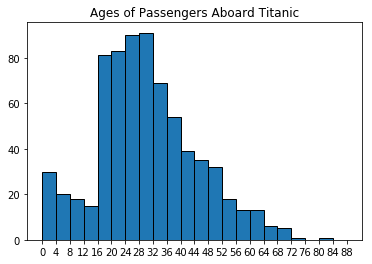

In [6]:
bins = np.arange(0, 92, 4)
plt.hist(X["Age"].values, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.title("Ages of Passengers Aboard Titanic")
plt.show()

There aren't very many children aboard the Titanic in the training sample. This graph gives a good feel for the distribution of children. In the function above, I create a variable "child" for every passenger under the age of 16.

### Random Forest
I decided to try a Random Forest first to see how that does. A decision tree seems to me a natural way to understand this problem. Most of the variables are categorical.

In [7]:
#Here we split our training set into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [8]:
n_estimators = [1000, 2500, 5000]
max_depth = [1, 3, 5, 10]
class_weights = ['balanced', None]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for wgt in class_weights:
            clf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            clf.fit(X_train, y_train)
            f1 = f1_score(y_train, np.argmax(clf.oob_decision_function_, 1))
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, wgt)
                
            

In [9]:
print("Best OOB F1: {}".format(best_f1))
print("Best params: {}".format(best_params))

Best OOB F1: 0.7762376237623761
Best params: (5000, 10, 'balanced')


In [10]:
clf1 = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1], class_weight=best_params[2])
clf1.fit(X_train, y_train)
test_predictions = clf1.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))


Test Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.88      0.86       103
          1       0.83      0.78      0.80        76

avg / total       0.84      0.84      0.84       179



In [11]:
feature_imp = sorted(list(zip(X.columns, clf.feature_importances_)), key=lambda x: x[1], reverse=True)


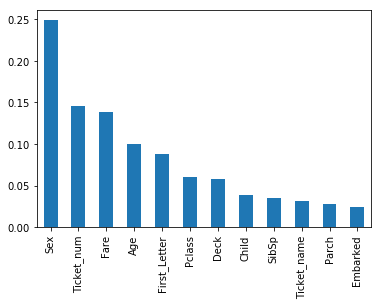

In [12]:
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='bar')

That's cool! As expected, gender played the biggest role of the variables in the dataset. I am surprised "Deck" didn't play a more substantial role. Perhaps there are just too many missing values for "Deck" for it to give our model much predictive power.

Because the average F1 was .84, I'm going to try another model. This time: Gradient Boosting.

### Gradient Boosting

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
clf = GradientBoostingClassifier()
gridsearch = GridSearchCV(clf, {"learning_rate": [.1, .01, .001], "n_estimators": [100, 1000, 5000], 
                                "max_depth": [1, 2, 3]}, scoring='f1')
gridsearch.fit(X_train, y_train)

/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100, 1000, 5000], 'max_depth': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [14]:
print("Best Params: {}".format(gridsearch.best_params_))
print("\nClassifcation Report:")
print(classification_report(y_test, gridsearch.predict(X_test)))

Best Params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 5000}

Classifcation Report:
             precision    recall  f1-score   support

          0       0.84      0.89      0.86       105
          1       0.82      0.76      0.79        74

avg / total       0.83      0.83      0.83       179



Gradient Boosting gave an average f1 of .83 which is about the same as our Random Forest model.

Now let's try a Support Vector Machine.

### Support Vector Machine

In [15]:
clf3 = SVC()
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)
print(clf3.score(X_train, y_train))


0.981741573034


This looks like a great score for SVM, but it performs worse on Kaggle than the Random Forest did.

Let's try naive bayes just for good measure.

### Naive Bayes

In [16]:
gnb = GaussianNB()
y_pred = gnb.fit(X, y).predict(X)
print("Number of mislabeled points out of a total of %d points : %d"
       % (X_train.shape[0], (y != y_pred).sum()))

Number of mislabeled points out of a total of 712 points : 294


Naive Bayes got only 59% accuracy.

### Kaggle Submission

The best model was Random Forest. I use that for my Kaggle submission:

In [17]:
labels=["Name", "PassengerId", "Cabin", "Ticket"]
X = Clean_Data(labels=labels, filename="test_titanic.csv", test=True)
y = clf1.predict(X)

In [18]:
np.savetxt("predictions.csv", y, delimiter=",")